In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import sys
import os
import scipy.stats as stats
from fears.population import Population
from fears.utils import plotter
from matplotlib import colors
from spatialentropy import leibovici_entropy, altieri_entropy

In [2]:
sys.path.append("./utils")
from myUtils import mkdir
from DoseResponseModel import DoseResponseModel

### Script parameters
runCASimulations = True # Whether to run the CA simulations to generate the data analysed in this script
jarFileName = "./HAL_dose_response.jar"

consumpt_rate = [0,0.001,0.01,0.1,0.5]

indx = 0

for cr in consumpt_rate:
    modelConfigDic = {'xDim':100,"yDim":100,'nTSteps':5000,"saveModelState":True,
                    "imageFrequency":-1,"consumpRate":cr,
                    "nReplicates":10,"dt":0.1,"initialGeometry":"square","initialDensity":0.01,
                    "saveFinalDiffImg":True,"saveFinalDiffGrid":True,"saveFinalPopGrid":True}

    dataDir = "./data/cellCountDoseResponse_{}".format(indx)
    imgDir = "./data/doseResponseImages"

    myModel = DoseResponseModel(jarFileName = jarFileName, outDir=dataDir, imageOutDir=imgDir, **modelConfigDic)
    myModel.Simulate()
    indx += 1

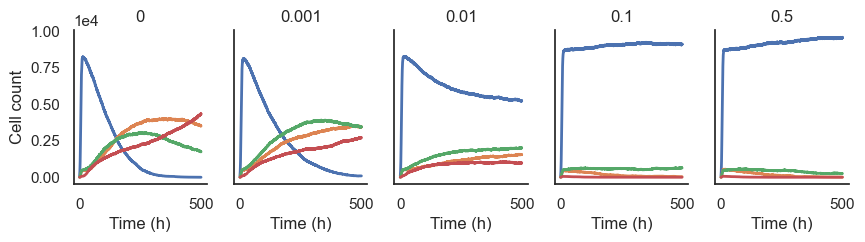

In [84]:
# plot representative traces

fig,ax = plt.subplots(ncols=len(consumpt_rate),nrows=1,figsize=(10,2),sharey=True)

for i,rate in enumerate(consumpt_rate):
    dataDir = "./data/cellCountDoseResponse_{}".format(i)
    dataFile = dataDir + '/RepId_0.csv'
    data = pd.read_csv(dataFile)
    for col in data.columns[3:7]:
        ax[i].plot(data['Time'],data[col],label=col,linewidth=2)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].set_title(rate)
    ax[i].set_xlabel('Time (h)')

ax[0].set_ylabel('Cell count')
ax[0].ticklabel_format(style='sci', axis='y', scilimits=(0,0))

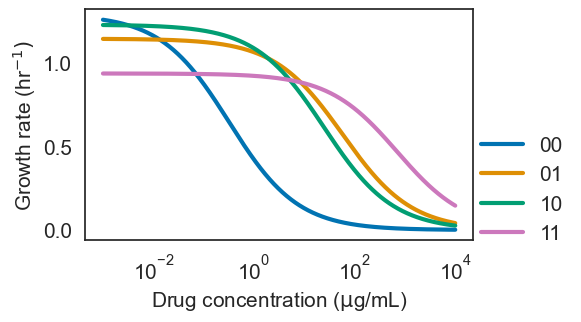

In [7]:
# plot MSW
from fears.population import Population
from fears.utils import plotter
p = Population(death_model = None,n_allele=2,fitness_data='random')
p.drugless_rates = [1.28949852, 1.14399848, 1.22802236, 0.93619847]
p.ic50 = [-0.49205992, 1.76224515,  1.39341393,  2.84653598]

fig,ax = plt.subplots(figsize=(5,3))
fig,ax = plotter.plot_fitness_curves(p,ax=ax,fig=fig,
                                      color_kwargs={'style':'solid',
                                                    'n_colors':4,
                                                    'palette':'colorblind'})

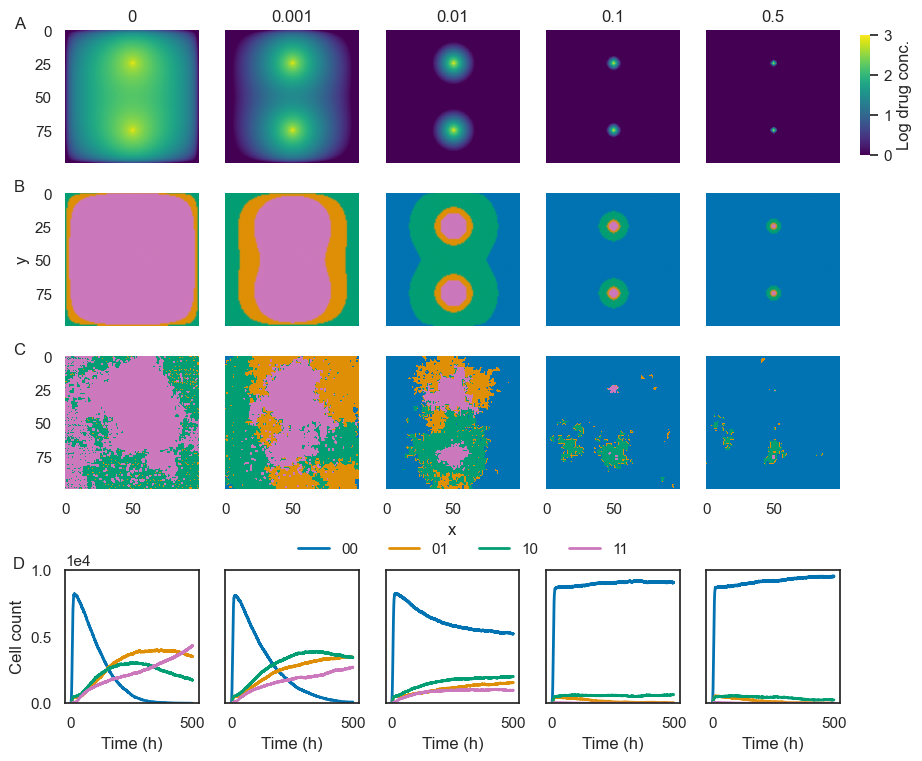

In [126]:
# plot everything in one figure
msw_map_list = []
pop_map_list = []
diffGridList = []

def get_most_fit_at_conc(data):
    most_fit_at_conc = np.zeros(data.shape)
    for z in range(data.shape[0]):
        for j in range(data.shape[1]):
            # conc = 10**data[z,j]
            conc = data[z,j]
            p_fit_list = p.gen_fit_land(conc)
            most_fit_at_conc[z,j] = int((np.argmax(p_fit_list)))
    return most_fit_at_conc

consumpt_rate = [0,0.001,0.01,0.1,0.5]
fig,ax_list = plt.subplots(ncols=len(consumpt_rate),nrows=3,figsize=(10,6),sharey=True,sharex=True)

img_t = np.zeros((100,100))

def get_cmap(most_fit_at_conc):
    cc = plotter.gen_color_cycler(style='solid',n_colors=4,palette='colorblind')
    cc_dict = cc.by_key()
    c = cc_dict['color']

    indx = [list(set(most_fit_at_conc.flatten()))]
    indx = [int(i) for i in indx]
    c = [c[i] for i in indx]

    cmap = colors.ListedColormap(c)
    bounds=indx
    norm = colors.BoundaryNorm(bounds, cmap.N)
    return cmap,norm

for i,rate in enumerate(consumpt_rate):
    # plot drug grid
    dataDir = "./data/cellCountDoseResponse_{}".format(i)
    dataFile = dataDir + '/RepId_0_diffGrid.csv'
    data = pd.read_csv(dataFile)
    for index,row in data.iterrows():
        if row['field'] > 0:
            img_t[int(row['x']),int(row['y'])] = row['field']
    diffGridList.append(img_t)
    img_t_log = np.log10(img_t)
    # ax[i].set_xlim(0,90)
    ax = ax_list[0,i]
    drug_img = ax.imshow(img_t_log,cmap='viridis',vmin=0,vmax=3)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    ax.set_title(rate)

    # plot msw grid
    most_fit_at_conc = get_most_fit_at_conc(img_t)
    cc = plotter.gen_color_cycler(style='solid',n_colors=4,palette='colorblind')
    cc_dict = cc.by_key()
    c = cc_dict['color']

    indx = list(set(most_fit_at_conc.flatten()))
    indx = [int(i) for i in indx]
    c = [c[i] for i in indx]

    cmap = colors.ListedColormap(c)
    bounds=indx
    norm = colors.BoundaryNorm(bounds, cmap.N)
    
    ax = ax_list[1,i]
    msw_img = ax.imshow(most_fit_at_conc,cmap=cmap,
              interpolation='gaussian',interpolation_stage='rgba')
    
    msw_map_list.append(most_fit_at_conc)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    # plot population grid
    dataDir = "./data/cellCountDoseResponse_{}".format(i)
    dataFile = dataDir + '/RepId_0_popGrid.csv'
    data = pd.read_csv(dataFile)
    for index,row in data.iterrows():
        # if row['field'] > 0:
        img_t[int(row['x']),int(row['y'])] = row['genotype']
    # img_t = np.log10(img_t)
    ax = ax_list[2,i]
    ax.imshow(img_t,vmin=0,vmax=3,cmap=cmap)
    # ax[i].set_xlim(0,90)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    pop_map_list.append(img_t)

# add colorbar for drug grid
cbar_ax = fig.add_axes([0.92, 0.67, 0.01, 0.2])
cbar = fig.colorbar(drug_img, cax=cbar_ax,label='Log drug conc.')
cbar.outline.set_visible(False)

# add another row for timetraces using inset axes

cc = plotter.gen_color_cycler(style='solid',n_colors=4,palette='colorblind')

# ax.set_prop_cycle(cc) 
inset_axes_list = []

for i in range(len(consumpt_rate)):
    ax = ax_list[2,i]
    pos = ax.get_position()

    axins = ax.inset_axes((0,-1.6,1,1))
    dataDir = "./data/cellCountDoseResponse_{}".format(i)
    dataFile = dataDir + '/RepId_0.csv'
    data = pd.read_csv(dataFile)

    axins.set_prop_cycle(cc)
    for col in data.columns[3:7]:
        axins.plot(data['Time'],data[col],label=col,linewidth=2)
    axins.ticklabel_format(axis='y',style='sci',scilimits=(0,0))
    axins.set_xlabel('Time (h)',fontsize=12)

    inset_axes_list.append(axins)

handles, labels = inset_axes_list[2].get_legend_handles_labels()
labels = ['00','01','10','11']
inset_axes_list[2].legend(handles,labels,frameon=False,ncol=4,loc=[-0.7,1.05])

# make sure all of the ylimits are the same
ymax = 0
for ax in inset_axes_list:
    if ax.get_ylim()[1] > ymax:
        ymax = ax.get_ylim()[1]

for ax in inset_axes_list:
    ax.set_ylim(0,ymax)

for ax in inset_axes_list[1:]:
    ax.set_yticklabels([])

inset_axes_list[0].set_ylabel('Cell count',fontsize=12)

   
ax_list[-1,2].set_xlabel('x',fontsize=12)
ax_list[1,0].set_ylabel('y',fontsize=12)

label_list = ['A','B','C','D']
for i in range(len(label_list)-1):
    ax = ax_list[i,0]
    ax.text(-0.3,1.1,label_list[i],transform=ax.transAxes,
            fontsize=12,va='top',ha='right')

inset_axes_list[0].text(-0.3,1.1,label_list[-1],transform=inset_axes_list[0].transAxes,
            fontsize=12,va='top',ha='right')

fig.savefig('figures/simulation_example_results.png',dpi=300,bbox_inches='tight')
# fig.suptitle('Varying field elimination rate',fontsize=12)


In [9]:
# compute entropy for MSW and population

def get_most_fit_at_conc_1d(data):
    most_fit_at_conc = np.zeros(data.shape)
    for z in range(data.shape[0]):
        # conc = 10**data[z,j]
        conc = data[z]
        p_fit_list = p.gen_fit_land(conc)
        most_fit_at_conc[z] = int((np.argmax(p_fit_list)))
    return most_fit_at_conc

n_replicates = 10
msw_entropy = []
pop_entropy = []
consumpt_rate_list = []
for i,rate in enumerate(consumpt_rate):
    dataDir = "./data/cellCountDoseResponse_{}".format(i)
    diffGridFile = dataDir + '/RepId_0_diffGrid.csv'
    diffGrid = pd.read_csv(diffGridFile)
    msw_list = get_most_fit_at_conc_1d(np.array(diffGrid['field']))
    msw_list = np.array(msw_list, dtype=int)
    points = np.array(diffGrid[['x','y']])
    e_msw = leibovici_entropy(points, msw_list)
    
    for j in range(n_replicates):
        dataDir = "./data/cellCountDoseResponse_{}".format(i)
        diffGridFile = dataDir + '/RepId_{}_popGrid.csv'.format(j)
        diffGrid = pd.read_csv(diffGridFile)
        point = np.array(diffGrid[['x','y']])
        types = np.array(diffGrid['genotype'])
        e_pop = leibovici_entropy(point, types)
        pop_entropy.append(e_pop.entropy)
        msw_entropy.append(e_msw.entropy)
        consumpt_rate_list.append(rate)

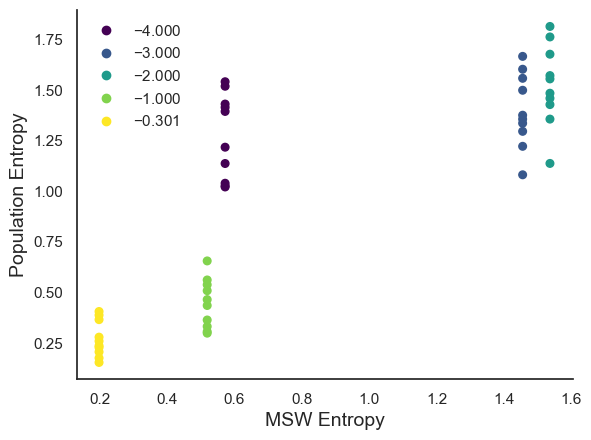

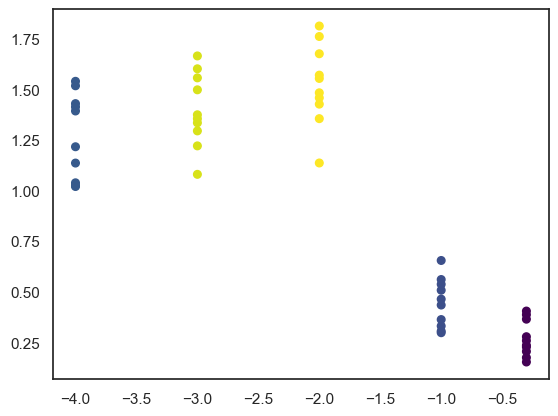

In [10]:
fig,ax = plt.subplots()

# consumpt_rate_list = np.array(consumpt_rate_list)
# consumpt_rate_list[consumpt_rate_list>0] = np.log10(consumpt_rate_list[consumpt_rate_list>0])
# consumpt_rate_list[consumpt_rate_list==0] = -4
consumpt_rate_log = np.array(consumpt_rate_list)
consumpt_rate_log[consumpt_rate_log>0] = np.log10(consumpt_rate_log[consumpt_rate_log>0])
consumpt_rate_log[consumpt_rate_log==0] = -4

sc = ax.scatter(msw_entropy,pop_entropy,c=consumpt_rate_log,cmap='viridis',s=30)
ax.set_xlabel('MSW Entropy',fontsize=14)
ax.set_ylabel('Population Entropy',fontsize=14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(*sc.legend_elements(),frameon=False)

fig,ax = plt.subplots()

ax.scatter(consumpt_rate_log,pop_entropy,c=msw_entropy,cmap='viridis',s=30)

In [11]:
# compute entropy for MSW and population

def get_most_fit_at_conc_1d(data):
    most_fit_at_conc = np.zeros(data.shape)
    for z in range(data.shape[0]):
        # conc = 10**data[z,j]
        conc = data[z]
        p_fit_list = p.gen_fit_land(conc)
        most_fit_at_conc[z] = int((np.argmax(p_fit_list)))
    return most_fit_at_conc

n_replicates = 10
msw_entropy = []
pop_entropy = []
consumpt_rate_list = []
for i,rate in enumerate(consumpt_rate):
    dataDir = "./data/cellCountDoseResponse_{}".format(i)
    diffGridFile = dataDir + '/RepId_0_diffGrid.csv'
    diffGrid = pd.read_csv(diffGridFile)
    msw_list = get_most_fit_at_conc_1d(np.array(diffGrid['field']))
    msw_list = np.array(msw_list, dtype=int)
    points = np.array(diffGrid[['x','y']])
    e_msw = altieri_entropy(points, msw_list)
    
    for j in range(n_replicates):
        dataDir = "./data/cellCountDoseResponse_{}".format(i)
        diffGridFile = dataDir + '/RepId_{}_popGrid.csv'.format(j)
        diffGrid = pd.read_csv(diffGridFile)
        point = np.array(diffGrid[['x','y']])
        types = np.array(diffGrid['genotype'])
        e_pop = altieri_entropy(point, types)
        pop_entropy.append(e_pop.entropy)
        msw_entropy.append(e_msw.entropy)
        consumpt_rate_list.append(rate)

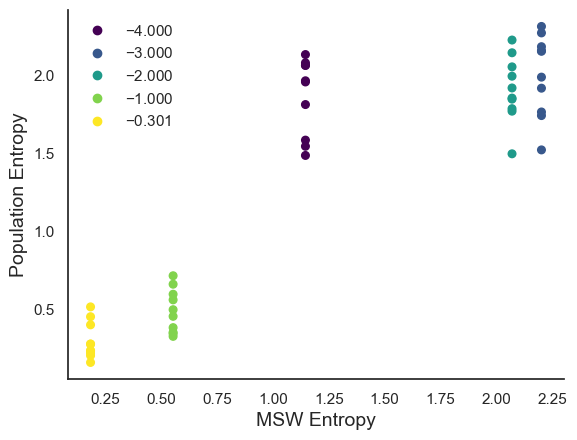

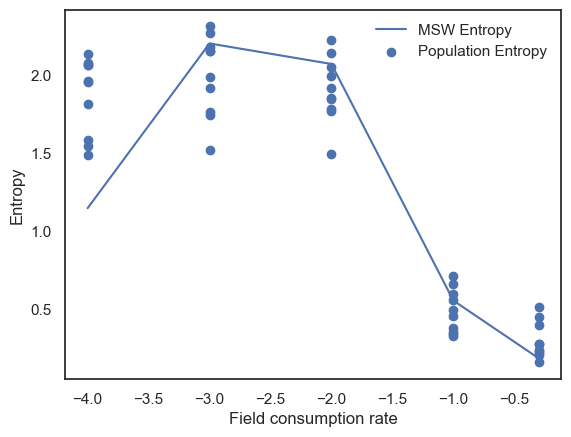

In [77]:
fig,ax = plt.subplots()

# consumpt_rate_list = np.array(consumpt_rate_list)
# consumpt_rate_list[consumpt_rate_list>0] = np.log10(consumpt_rate_list[consumpt_rate_list>0])
# consumpt_rate_list[consumpt_rate_list==0] = -4
consumpt_rate_log = np.array(consumpt_rate_list)
consumpt_rate_log[consumpt_rate_log>0] = np.log10(consumpt_rate_log[consumpt_rate_log>0])
consumpt_rate_log[consumpt_rate_log==0] = -4

sc = ax.scatter(msw_entropy,pop_entropy,c=consumpt_rate_log,cmap='viridis',s=30)
ax.set_xlabel('MSW Entropy',fontsize=14)
ax.set_ylabel('Population Entropy',fontsize=14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(*sc.legend_elements(),frameon=False)

fig,ax = plt.subplots()

ax.plot(consumpt_rate_log,msw_entropy,label='MSW Entropy')
ax.set_xlabel('Field consumption rate')
ax.set_ylabel('Entropy')
ax.scatter(consumpt_rate_log,pop_entropy,label='Population Entropy')
ax.legend(frameon=False)

In [42]:
# analyze MSW share versus population share

def get_most_fit_at_conc_1d(data):
    most_fit_at_conc = np.zeros(data.shape)
    for z in range(data.shape[0]):
        # conc = 10**data[z,j]
        conc = data[z]
        p_fit_list = p.gen_fit_land(conc)
        most_fit_at_conc[z] = int((np.argmax(p_fit_list)))
    return most_fit_at_conc

pop_count = []
msw_count = []

genotypes = [0,1,2,3]

genotype_list = []
consumpt_list = []

for i,rate in enumerate(consumpt_rate):
    dataDir = "./data/cellCountDoseResponse_{}".format(i)
    
    for j in range(n_replicates):
        # dataDir = "./data/cellCountDoseResponse_{}".format(i)
        popGridFile = dataDir + '/RepId_{}_popGrid.csv'.format(j)
        diffGridFile = dataDir + '/RepId_{}_diffGrid.csv'.format(j)
        popGrid = pd.read_csv(popGridFile)
        pop_types = np.array(popGrid['genotype'])

        diffGrid = pd.read_csv(diffGridFile)
        field = diffGrid['field']
        most_fit_at_conc = get_most_fit_at_conc_1d(field)
        for g in genotypes:
            pop_count.append(np.sum(pop_types==g))
            msw_count.append(np.sum(most_fit_at_conc==g))
            # color_list.append(g)
            genotype_list.append(g)
            consumpt_list.append(rate)


# ax.legend(*sc.legend_elements(),frameon=False)

Text(0, 0.5, 'Count per Genotype')

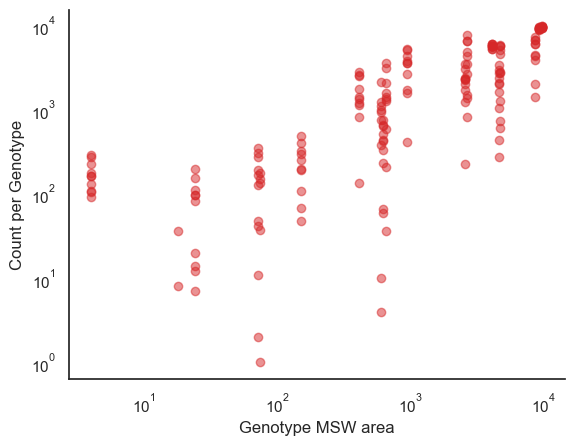

In [81]:
fig,ax = plt.subplots()

# colormap = plt.cm.get_cmap('viridis')  # You can choose a different colormap if you prefer

# # Normalize your values to the range [0, 1] to match the colormap range
# norm = plt.Normalize(min(consumpt_rate), max(consumpt_rate))

# # Get the colors for each value based on the colormap
# colors = [colormap(norm(val)) for val in consumpt_list]

# sc = ax.scatter(msw_count,pop_count,c=colors, cmap=colormap)
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.legend(*sc.legend_elements(),frameon=False);
msw_count = np.array(msw_count)
pop_count = np.array(pop_count)

for rate in consumpt_rate:
    indx = np.where(consumpt_list == rate)[0]
    ax.scatter(msw_count[indx],pop_count[indx],label=rate,color='tab:red',alpha=0.5)

ax.set_xscale('log')
ax.set_yscale('log')
# ax.legend(frameon=False);
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Genotype MSW area')
ax.set_ylabel('Count per Genotype') 